In [3]:
import sys
sys.path.append('../..')

import eeg_decoder
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sista
from statsmodels.stats.multitest import multipletests

import scipy.io as io

np.random.seed(42)
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns

In [4]:
OVERWRITE = False
np.random.seed(42)

In [5]:
experiment_name = 'data'
data_dir = f'./data/'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False,trim_timepoints=[-200,1500])
eyefiles = sorted(list(exp.data_dir.glob('*eyetracking*.mat')))

In [6]:
ss1,ss3 = [11,21],[13,23]
color,ori = [11,13],[21,23]

In [7]:
time_window = 25 
time_step = 25
trial_bin_size = 15 
n_splits = 1000
group_dict = OrderedDict([('SS1_col',[11]),('SS2_col',[12]), ('SS1_mot',[21]),('SS2_mot',[22])])
wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict)
clfr = eeg_decoder.Classification(wrangl,exp.nsub,num_labels=2)
clfr_eyes = eeg_decoder.Classification(wrangl,exp.nsub,num_labels=2)

In [8]:
if OVERWRITE:
    bad_eye_subs = []
    for isub in range(exp.nsub):

        print(isub)
        xdata_eeg,ydata = exp.load_eeg(isub)
        eyedata = io.loadmat(eyefiles[isub])['eyetracking']
        eyedata = np.rollaxis(eyedata, -1)  # reorder to trial, feat, time
        try:
            xdata = np.concatenate([xdata_eeg,eyedata],axis=1)  # combine eyedata so it goes along for the ride
        except:
            bad_eye_subs.append(isub)
            xdata = xdata_eeg

        xdata,ydata = wrangl.group_labels(xdata,ydata)

        for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_split_data(xdata,ydata):

            # this will set the same number of ss1 and ss2 for each attended feature
            X_train_all, X_test_all, y_train, y_test = wrangl.balance_data(X_train_all, X_test_all, y_train, y_test)

            # relabel to color vs motion
            train_col = (y_train==0) | (y_train==1)
            train_mot = (y_train==2) | (y_train==3)
            y_train[train_col] = 0
            y_train[train_mot] = 1

            test_col = (y_test==0) | (y_test==1)
            test_mot = (y_test==2) | (y_test==3)
            y_test[test_col] = 0
            y_test[test_mot] = 1

            y_test_shuffle = np.random.permutation(y_test)

            for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):

                # clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

                X_train_eeg = X_train[:, :30]
                X_test_eeg = X_test[:, :30]
                clfr.decode(X_train_eeg,X_test_eeg,y_train,y_test,y_test_shuffle,isub)
                if X_train.shape[1] > 30:  # if they have eye data
                    X_train_eye = X_train[:, 30:]
                    X_test_eye = X_test[:, 30:]
                    clfr_eyes.decode(X_train_eye,X_test_eye,y_train,y_test,y_test_shuffle,isub)

    interp = eeg_decoder.Interpreter(clfr,subtitle='attended_feat')
    interp.save_results(timestamp=False)

    interp_eyes = eeg_decoder.Interpreter(clfr_eyes, subtitle='attended_feat_eyes')
    interp_eyes.save_results(timestamp=False)
else:
    bad_eye_subs=[14]

In [9]:
def interpret_results(subtitle, bad_eye_subs=None, ylim=[-1, 2], stim_time=[0, 500], savefig=True):
    interp = eeg_decoder.Interpreter()
    interp.load_results(subtitle)
    if bad_eye_subs is not None:
        interp.confidence_scores = np.delete(interp.confidence_scores, bad_eye_subs, axis=0)
        interp.confidence_scores_shuff = np.delete(interp.confidence_scores_shuff, bad_eye_subs, axis=0)

    interp.colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

    interp.plot_hyperplane(
        stim_time=stim_time,
        ylim=[-3,3],stim_label_xy=[130,3.1],label_text_ys=[-1.95,1.95],arrow_ys=[-.5,.5],
        savefig=False,subtitle='Blank',legend_pos='lower left')
    
    hyp_diff = interp.confidence_scores[..., 1] - interp.confidence_scores[..., 0]  # SS2_col - SS1_col
    hyp_scores = np.mean(hyp_diff, axis=2)

    hyp_diff_shuff = interp.confidence_scores_shuff[..., 1] - interp.confidence_scores_shuff[..., 0]
    hyp_scores_shuff = np.mean(hyp_diff_shuff, axis=2)

    # ylim = [-1, 2]
    stim_lower = ylim[0] + 0.01
    stim_upper = ylim[1]

    ax = plt.subplot(111)


    ax.fill_between(
            stim_time, [stim_lower, stim_lower], [stim_upper, stim_upper], color="gray", alpha=0.5
        )

    ax.plot(interp.t, np.zeros((len(interp.t))), "--", color="gray")
    # ax.axhline(y=0, color="grey", linestyle="--")


    # plot the shuffled labels results
    mean, upper, lower = interp.get_plot_line(hyp_scores_shuff)
    ax.plot(interp.t, mean, 'gray', label='Shuffle')
    ax.fill_between(interp.t, upper, lower, color='gray', alpha=0.5)

    # plot the actual results
    mean, upper, lower = interp.get_plot_line(hyp_scores)
    ax.plot(interp.t, mean, 'tab:blue', label='Attended Feature')
    ax.fill_between(interp.t, upper, lower, color=interp.colors[0], alpha=0.5)

    _, ps = sista.ttest_rel(hyp_scores, hyp_scores_shuff, axis=0, alternative="greater")
    _, corrected_p, _, _ = multipletests(ps, method="fdr_bh")
    sig05 = corrected_p < 0.05
    plt.scatter(
        interp.t[sig05],
        np.ones(sum(sig05))*-.4,
        marker="s",
        s=33,
        c=interp.colors[0]
    )

    plt.title(f'Hyperplane contrast: {subtitle}')
    _ = plt.legend()
    if savefig:
        plt.savefig(f'output/figures/hyperplane_contrast_{subtitle}.svg')
    plt.show()
    plt.close()
        
    return hyp_diff

In [10]:
# semi-arbitrary interpreter object for holding info throuhgout
interp = eeg_decoder.Interpreter()
interp.load_results('attended_feat')
interp.colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

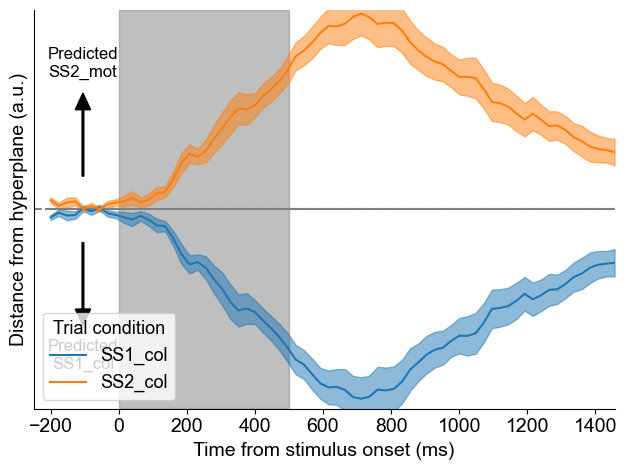

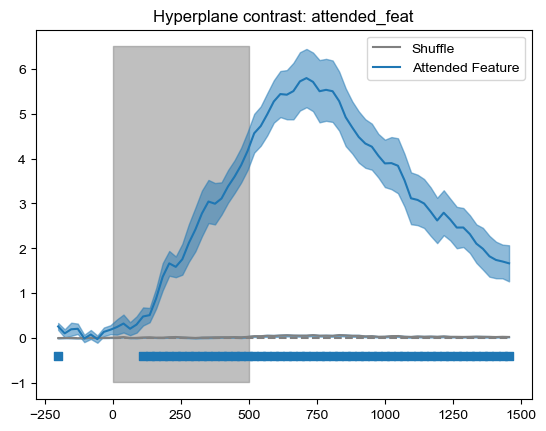

3.69555734336241 1.5641321565078357


In [11]:
diff_eeg_full = interpret_results('attended_feat', ylim=[-1, 6.5])
sub_delay_contrasts = diff_eeg_full.mean(2)[:, interp.t > 250].mean(1)
print(sub_delay_contrasts.mean(), sub_delay_contrasts.std())

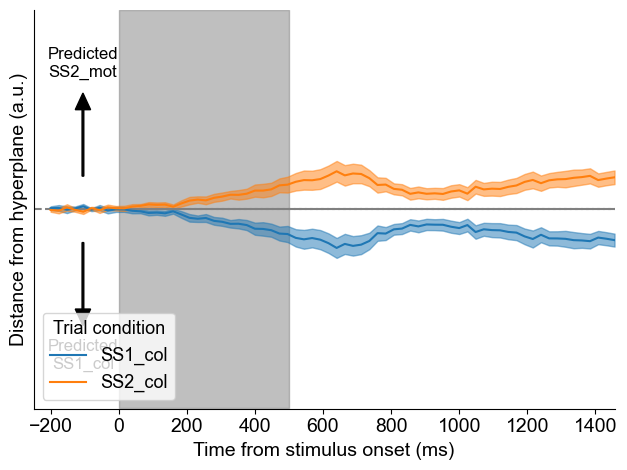

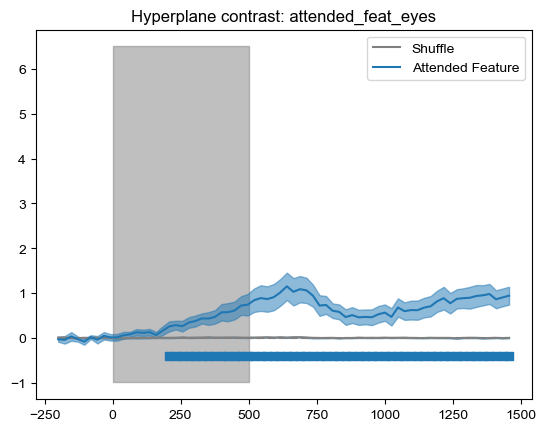

In [12]:
diff_eyes = interpret_results('attended_feat_eyes', bad_eye_subs=bad_eye_subs, ylim=[-1, 6.5])

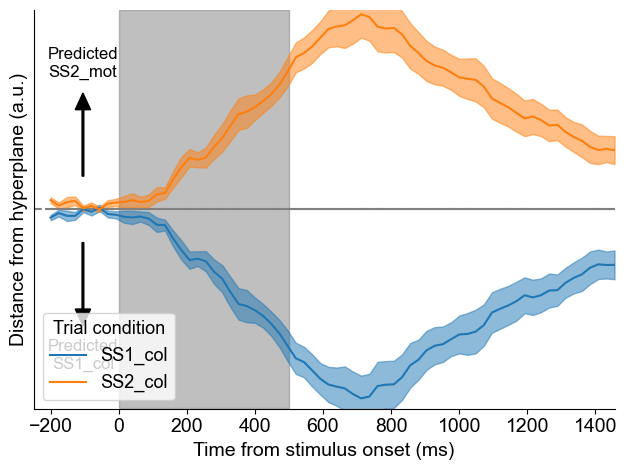

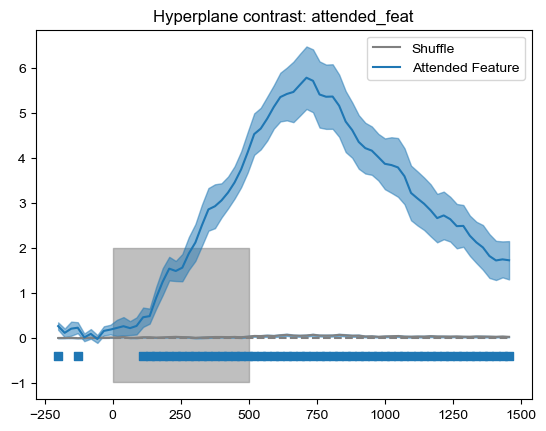

In [13]:
diff_eeg = interpret_results('attended_feat', bad_eye_subs=bad_eye_subs, savefig=False)

In [19]:
def correlate_contrasts(interp, cond_diff_eyes, cond_diff_eeg, subtitle, stim_time=[0, 500], ylim = [-.1, .1], ylim_stds = [0, 2]):

    nsubs = cond_diff_eyes.shape[0]
    ntimes = cond_diff_eyes.shape[1]
    cond_corrs = np.zeros((nsubs,ntimes))

    for isub in range(nsubs):
        for t in range(ntimes):
            # correlations are immediately Fisher transformed
            cond_corrs[isub, t] = np.arctanh(np.corrcoef(cond_diff_eyes[isub, t], cond_diff_eeg[isub, t])[0, 1])

    # plot correlations
    stim_lower = ylim[0] + 0.01
    stim_upper = ylim[1]

    ax = plt.subplot(111)

    ax.fill_between(
            stim_time, [stim_lower, stim_lower], [stim_upper, stim_upper], color="gray", alpha=0.5
        )

    ax.plot(interp.t, np.zeros((len(interp.t))), "--", color="gray")

    i = 0
    mean, upper, lower = interp.get_plot_line(cond_corrs)
    ax.plot(interp.t, mean, interp.colors[i])
    ax.fill_between(interp.t, upper, lower, color=interp.colors[i], alpha=0.5)

    _, ps = sista.ttest_1samp(cond_corrs, popmean=0, axis=0, alternative="greater")
    _, corrected_p, _, _ = multipletests(ps, method="fdr_bh")
    sig05 = corrected_p < 0.05
    if sum(sig05):
        plt.scatter(
            interp.t[sig05],
            np.ones(sum(sig05))*-.05,
            marker="s",
            s=33,
            c=interp.colors[i]
        )
    else:
        print(f'no significant correlations for condition {subtitle}')

    plt.title("Fisher's z of permutation contrasts between EEG and eye models")
    sns.despine()
    plt.savefig(f'output/figures/corrs_{subtitle}.svg')
    plt.show()
    plt.close()

    # look at standard deviations across permutations
    cond_std_eyes = np.zeros((nsubs,ntimes))
    cond_stds_eeg = np.zeros((nsubs,ntimes))

    for isub in range(nsubs):
        for t in range(ntimes):
            cond_std_eyes[isub, t] = np.std(cond_diff_eyes[isub, t])
            cond_stds_eeg[isub, t] = np.std(cond_diff_eeg[isub, t])


    # convert to data frames
    cond_std_eyes=pd.DataFrame(cond_std_eyes).T
    cond_std_eyes['time'] = interp.t
    cond_std_eyes = cond_std_eyes.melt(id_vars='time',var_name='subject',value_name="std")
    cond_std_eyes['Data Type'] = 'Eye'

    cond_stds_eeg=pd.DataFrame(cond_stds_eeg).T
    cond_stds_eeg['time'] = interp.t
    cond_stds_eeg = cond_stds_eeg.melt(id_vars='time',var_name='subject',value_name="std")
    cond_stds_eeg['Data Type'] = 'EEG'

    stds = pd.concat([cond_std_eyes,cond_stds_eeg])
    
    stim_lower = ylim_stds[0] + 0.01
    stim_upper = ylim_stds[1]

    ax = plt.subplot(111)
    ax.fill_between(
            stim_time, [stim_lower, stim_lower], [stim_upper, stim_upper], color="gray", alpha=0.5
        )

    sns.lineplot(data=stds,x='time',y="std", style='Data Type')
    _ = plt.ylim(ylim_stds)

    plt.title("Standard deviation of contrasts across permutations")
    _ = plt.legend()
    sns.despine()
    plt.savefig(f'output/figures/stds_{subtitle}.svg')
    plt.show()
    plt.close()
    

no significant correlations for condition attended_feat


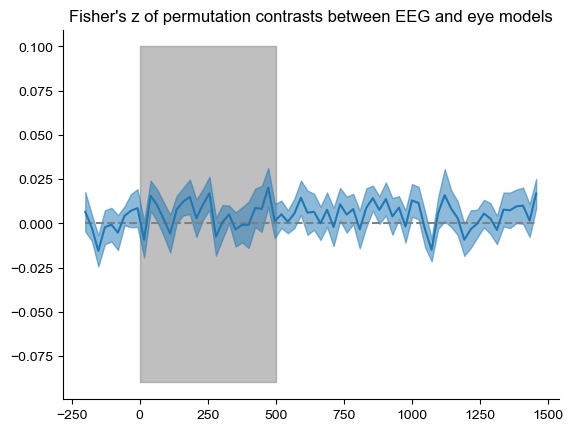

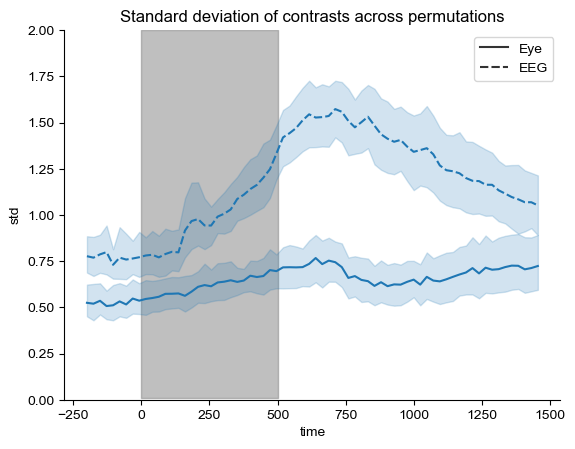

In [20]:
correlate_contrasts(interp, diff_eyes, diff_eeg, subtitle='attended_feat')

# OLD

In [ ]:
break

In [11]:
interp = eeg_decoder.Interpreter()
interp.load_results('attended_feat')

In [12]:
interp.colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

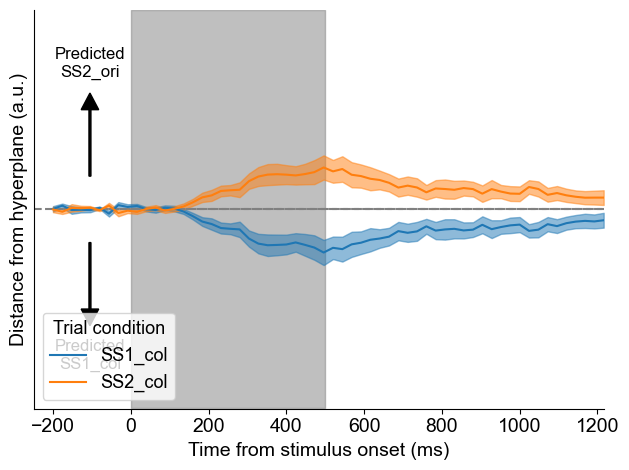

In [13]:
interp.plot_hyperplane(
    stim_time=[0,500],
    ylim=[-3,3],stim_label_xy=[130,3.1],label_text_ys=[-1.95,1.95],arrow_ys=[-.5,.5],
    savefig=False,subtitle='Blank',legend_pos='lower left')

In [14]:
hyp_diff = interp.confidence_scores[..., 1] - interp.confidence_scores[..., 0]  # SS2_col - SS1_col
hyp_scores = np.mean(hyp_diff, axis=2)

hyp_diff_shuff = interp.confidence_scores_shuff[..., 1] - interp.confidence_scores_shuff[..., 0]
hyp_scores_shuff = np.mean(hyp_diff_shuff, axis=2)

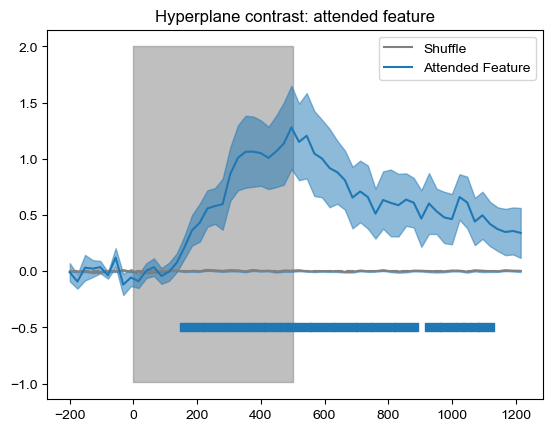

In [15]:
stim_time=[0, 500]
ylim = [-1, 2]
stim_lower = ylim[0] + 0.01
stim_upper = ylim[1]

ax = plt.subplot(111)


ax.fill_between(
        [0, 500], [stim_lower, stim_lower], [stim_upper, stim_upper], color="gray", alpha=0.5
    )

ax.plot(interp.t, np.zeros((len(interp.t))), "--", color="gray")
# ax.axhline(y=0, color="grey", linestyle="--")

labels = ["Attended Feature"]
scores = hyp_scores
i = 0
# plot the shuffled labels results
mean, upper, lower = interp.get_plot_line(hyp_scores_shuff)
ax.plot(interp.t, mean, 'gray', label='Shuffle')
ax.fill_between(interp.t, upper, lower, color=interp.colors[i], alpha=0.5)

# plot the actual results
mean, upper, lower = interp.get_plot_line(hyp_scores)
ax.plot(interp.t, mean, 'tab:blue', label='Attended Feature')
ax.fill_between(interp.t, upper, lower, color=interp.colors[i], alpha=0.5)

# _, ps = sista.ttest_1samp(scores, popmean=0, axis=0, alternative="greater")
_, ps = sista.ttest_rel(hyp_scores, hyp_scores_shuff, axis=0, alternative="greater")
_, corrected_p, _, _ = multipletests(ps, method="fdr_bh")
sig05 = corrected_p < 0.05
plt.scatter(
    interp.t[sig05],
    np.ones(sum(sig05))*-.2*(i+1)-.3,
    marker="s",
    s=33,
    c=interp.colors[i]
)

plt.title('Hyperplane contrast: attended feature')
_ = plt.legend()

# repeat with eyes